In [ ]:
import torch
from torch import nn

import numpy as np

In [ ]:
text = ['hey how are you',
        'good i am fine',
        'have a nice day',
        'where are you',
        ]

# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))

# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

In [ ]:
print(char2int)

{'d': 0, 'r': 1, 'u': 2, 'y': 3, 'n': 4, 'f': 5, 'w': 6, 'g': 7, 'i': 8, ' ': 9, 'a': 10, 'v': 11, 'm': 12, 'e': 13, 'o': 14, 'c': 15, 'h': 16}


In [ ]:
maxlen = len(max(text, key=len))
print("The longest string has {} characters".format(maxlen))

The longest string has 15 characters


In [ ]:
# Padding

# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i])<maxlen:
        text[i] += ' '

In [ ]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
    input_seq.append(text[i][:-1])

    # Remove firsts character for target sequence
    target_seq.append(text[i][1:])
    print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

Input Sequence: hey how are yo
Target Sequence: ey how are you
Input Sequence: good i am fine
Target Sequence: ood i am fine 
Input Sequence: have a nice da
Target Sequence: ave a nice day
Input Sequence: where are you 
Target Sequence: here are you  


In [ ]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

In [ ]:
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)

    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [ ]:
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print("Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(input_seq.shape))

Input shape: (4, 14, 17) --> (Batch Size, Sequence Length, One-Hot Encoding Size)


In [ ]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [ ]:
# Instantiate the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Training Run
input_seq = input_seq.to(device)
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(input_seq)
    output = output.to(device)
    target_seq = target_seq.to(device)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100............. Loss: 2.4085
Epoch: 20/100............. Loss: 1.9523
Epoch: 30/100............. Loss: 1.5637
Epoch: 40/100............. Loss: 1.2132
Epoch: 50/100............. Loss: 0.9179
Epoch: 60/100............. Loss: 0.6785
Epoch: 70/100............. Loss: 0.4880
Epoch: 80/100............. Loss: 0.3478
Epoch: 90/100............. Loss: 0.2518
Epoch: 100/100............. Loss: 0.1886


In [ ]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character = character.to(device)

    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden

In [ ]:
def sample(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [ ]:
sample(model, 15, 'good')

'good i am fine '

In [ ]:
sample(model, 15, 'have')

'have a nice day'

In [ ]:
sample(model, 15, 'where')

'where are you  '

In [ ]:
import math

with torch.no_grad():
    model.eval()
    output, _ = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())

perplexity = math.exp(loss.item())
print("Perplexity:", perplexity)


Perplexity: 1.2016123646109573


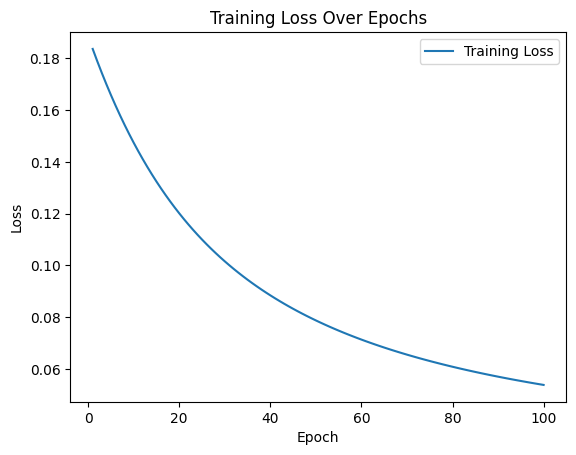

In [ ]:
import matplotlib.pyplot as plt

losses = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(range(1, n_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
